In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Read EPW

In [313]:
ep_weather_path = r"C:\Users\sebas\Documents\GitHub\ClimAIte\EMS_work\test_files\GBR_WAL_Lake.Vyrnwy.034100_TMYx.2007-2021.epw"

epw = pd.read_csv(ep_weather_path, skiprows=8, header=None)
# epw # year, month, day, hour, minute, source, temperature, dew point, RH, atmospheric pressure, radiation
# epw[6] # temperature columns

Combined DF

Populate data from runs

In [570]:
df = pd.DataFrame()

dates = pd.date_range('2007-01-01', periods=8760, freq='H')
s = pd.Series(dates)
df['Date'] = s
df['open'] = (df['Date'].dt.dayofweek < 5) & (df['Date'].dt.hour.between(8, 15, inclusive='both'))

df['Ext Temperature'] = epw[6]


# Read from runs

base_path = r"W:\Insync\GDrive\Main\TU Delft\Thesis\DRL runs 11"
# EPBaseline', 'RLBaseNoForesight', 'RL24hAllRNN', 'RL24hNoSolarRNN', 'RL04hAllRNN', 'RL04hNoSolarRNN', 'RL04hFlatInput'
control_types_list = ['EPBaseline', 'EPBaseline190', 'EPBaseline195', 'RL24hAllRNN', 'RL04hAllRNN', 'RL24hNoSolarRNN', 'RL04hNoSolarRNN']#, 'RL04hFlatInput']

control_pretty_names_list = ['Baseline EnergyPlus simple schedule', 'RL 24h Foresight RNN', 'RL 4h Foresight RNN', 'RL No Foresight', 'RL 24h Foresight RNN w/o Solar', 'RL 4h Foresight RNN w/o Solar', 'RL 4h Foresight flat inputs']
control_pretty_names_list = control_pretty_names_list[0:len(control_types_list)]


building_types_list = [ 'Building-InsuBASE-MassBASE', #0
                        'Building-InsuBASE-MassDW', #1
                        'Building-InsuBASE-MassUP', #2
                        'Building-InsuDW-MassBASE', #3
                        'Building-InsuDW-MassDW', #4
                        'Building-InsuDW-MassUP', #5
                        'Building-InsuUP-MassBASE', #6
                        'Building-InsuUP-MassDW', #7
                        'Building-InsuUP-MassUP'] #8
building = building_types_list[0] # 'Building-InsuBASE-MassBASE'


for control in control_types_list:

    meter_path = os.path.join(base_path, building, control, 'out', 'eplusmtr.csv')
    dfmeter = pd.read_csv(meter_path)
    heat_MJ = dfmeter['DistrictHeating:Facility [J](TimeStep)'] / 1_000_000
    # base_heat_kWh_m2 = heat_MJ_total * 277.8 / building_area_m2

    epluscsv_path = os.path.join(base_path, building, control, 'out', 'eplusout.csv')
    epluscsv = pd.read_csv(epluscsv_path)
    temperatures = epluscsv['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)']

    deg_hour_cold = (20 - epluscsv[ (epluscsv['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) & (df['open']) ]['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)'] )
    """
    (20 - df[(df['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) &
    (df['Date/Time'].dt.dayofweek < 5) &
    (df['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
    (df.index >= day_range_hours[0]) &
    (df.index <= day_range_hours[1])
    ]['Z1_GROUND_FLOOR:Zone Operative Temperature [C](Hourly)']).sum()
    """
    df[f'{control} MJ'] = heat_MJ
    df[f'{control} Temp'] = temperatures
    df[f'{control} deg-h cold'] = deg_hour_cold
    # df[f'{control} deg-hour'] = 

df.fillna(0, inplace=True)
df = df.set_index('Date')
df[6:]

,open,Ext Temperature,EPBaseline MJ,EPBaseline Temp,EPBaseline deg-h cold,EPBaseline190 MJ,EPBaseline190 Temp,EPBaseline190 deg-h cold,EPBaseline195 MJ,EPBaseline195 Temp,...,RL24hAllRNN deg-h cold,RL04hAllRNN MJ,RL04hAllRNN Temp,RL04hAllRNN deg-h cold,RL24hNoSolarRNN MJ,RL24hNoSolarRNN Temp,RL24hNoSolarRNN deg-h cold,RL04hNoSolarRNN MJ,RL04hNoSolarRNN Temp,RL04hNoSolarRNN deg-h cold
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 06:00:00,False,4.2,33.268112,19.708004,0.0,26.080059,18.783222,0.000000,29.579198,19.245908,...,0.000000,61.450266,19.240453,0.000000,46.308303,19.479429,0.000000,34.426725,19.695524,0.0
2007-01-01 07:00:00,False,4.2,8.678329,19.733451,0.0,1.253229,18.808447,0.000000,4.865809,19.271215,...,0.000000,12.853280,19.574741,0.000000,4.313323,19.645552,0.000000,9.497297,19.723897,0.0
2007-01-01 08:00:00,True,4.0,0.000000,20.022775,0.0,0.000000,19.064234,0.935766,0.000000,19.533359,...,0.858475,0.000000,19.845843,0.154157,0.000000,19.937662,0.062338,0.000000,20.044519,0.0
2007-01-01 09:00:00,True,3.0,0.000000,20.117908,0.0,0.000000,19.093414,0.906586,0.000000,19.695902,...,0.130111,0.000000,20.016428,0.000000,0.000000,20.110993,0.000000,0.000000,20.225199,0.0
2007-01-01 10:00:00,True,1.1,0.000000,20.226482,0.0,0.000000,19.322951,0.677049,0.000000,19.830213,...,0.000000,0.000000,20.223171,0.000000,0.000000,20.254417,0.000000,0.000000,20.263007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31 19:00:00,False,9.5,0.000000,20.183835,0.0,0.000000,19.538650,0.000000,0.000000,19.855395,...,0.000000,0.000000,19.719068,0.000000,0.000000,19.777145,0.000000,1.978100,20.012617,0.0
2007-12-31 20:00:00,False,9.5,5.095232,19.915411,0.0,0.000000,19.339165,0.000000,0.000000,19.657448,...,0.000000,0.000000,19.522694,0.000000,0.000000,19.577660,0.000000,0.000000,19.683035,0.0
2007-12-31 21:00:00,False,9.4,23.294984,19.841162,0.0,10.832745,19.012382,0.000000,16.921077,19.420471,...,0.000000,0.000000,19.120584,0.000000,3.118106,19.192109,0.000000,0.000000,19.340275,0.0


In [571]:
# for control in control_types_list:
#     df[f'{control} MJ'][:4000].rolling(50).mean().plot()

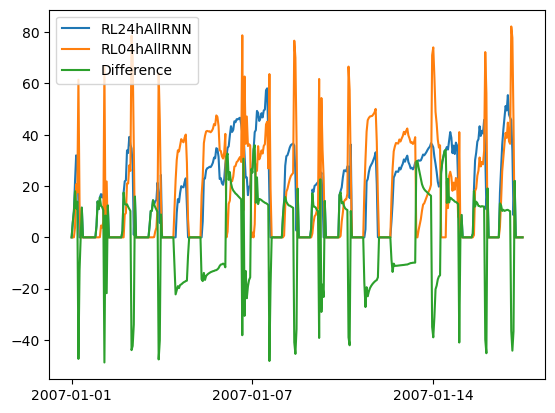

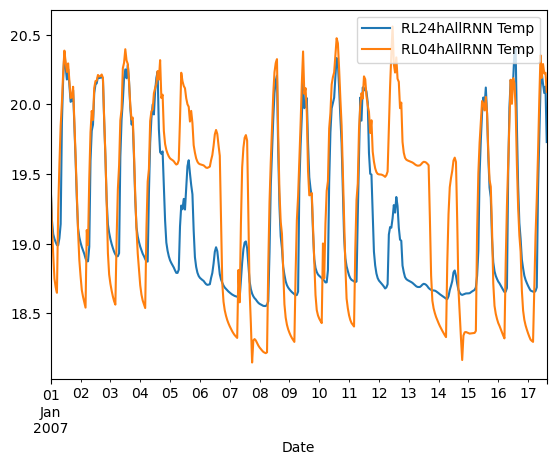

In [632]:
# max = 400
# x = df['EPBaseline MJ'][:max].index
# y = df['EPBaseline MJ'][:max] - df['RL04hFlatInput MJ'][:max] 
# # y = df['EPBaseline MJ'][:max] - df['RLBaseNoForesight MJ'][:max] 

# plt.plot(x,y)
# # # EPBaseline Joules
# df['EPBaseline MJ'][:max].plot()
# df['RL04hFlatInput MJ'][:max].plot()
# plt.legend()
# plt.show()



# df['EPBaseline Temp'][:max].plot()
# df['RL04hFlatInput Temp'][:max].plot()
# plt.legend()
# plt.show()



x = df['RL24hAllRNN MJ'][:max].index
y = df['RL24hAllRNN MJ'][:max] - df['RL04hAllRNN MJ'][:max] 
# y = df['EPBaseline MJ'][:max] - df['RLBaseNoForesight MJ'][:max] 


# # EPBaseline Joules
h= df['RL24hAllRNN MJ'][:max]
u= df['RL04hAllRNN MJ'][:max]
plt.plot(x,h)
plt.plot(x,u)
plt.plot(x,y)
plt.xticks([value for i, value in enumerate(x) if i % 160 ==0])
plt.legend(('RL24hAllRNN','RL04hAllRNN','Difference'))
plt.show()

# x = df['EPBaseline Temp'][:max].index
# y = df['EPBaseline Temp'][:max] - df['RL24hAllRNN Temp'][:max] 
# y = df['EPBaseline MJ'][:max] - df['RLBaseNoForesight MJ'][:max] 

# plt.plot(x,y)
# # EPBaseline Joules
df['RL24hAllRNN Temp'][:max].plot()
df['RL04hAllRNN Temp'][:max].plot()
plt.legend()

plt.show()


# df['RLBaseNoForesight MJ'][:max].plot()
# RL04hFlatInput MJ

# x = df['EPBaseline Temp'][:max].index
# y = df['EPBaseline Temp'][:max] - df['RL04hFlatInput Temp'][:max] 
# y = df['EPBaseline MJ'][:max] - df['RLBaseNoForesight MJ'][:max] 

# plt.plot(x,y)
# EPBaseline Joules
# df['EPBaseline Temp'][:max].plot()
# df['RL04hFlatInput Temp'][:max].plot()

In [573]:
df[2456:]

,open,Ext Temperature,EPBaseline MJ,EPBaseline Temp,EPBaseline deg-h cold,EPBaseline190 MJ,EPBaseline190 Temp,EPBaseline190 deg-h cold,EPBaseline195 MJ,EPBaseline195 Temp,...,RL24hAllRNN deg-h cold,RL04hAllRNN MJ,RL04hAllRNN Temp,RL04hAllRNN deg-h cold,RL24hNoSolarRNN MJ,RL24hNoSolarRNN Temp,RL24hNoSolarRNN deg-h cold,RL04hNoSolarRNN MJ,RL04hNoSolarRNN Temp,RL04hNoSolarRNN deg-h cold
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-13 08:00:00,True,2.6,0.000000,20.282637,0.0,0.000000,19.330830,0.669170,0.000000,19.850821,...,0.583265,0.000000,20.257519,0.0,0.000000,19.762410,0.237590,0.000000,20.250959,0.0
2007-04-13 09:00:00,True,3.0,0.000000,20.270186,0.0,0.000000,19.444443,0.555557,0.000000,19.882101,...,0.465378,0.000000,20.245748,0.0,0.000000,19.771863,0.228137,0.000000,20.231496,0.0
2007-04-13 10:00:00,True,4.0,0.000000,20.306923,0.0,0.000000,19.648955,0.351045,0.000000,20.010660,...,0.252774,0.000000,20.286058,0.0,0.000000,19.965945,0.034055,0.000000,20.323497,0.0
2007-04-13 11:00:00,True,5.2,0.000000,20.515201,0.0,0.000000,19.891294,0.108706,0.000000,20.233496,...,0.011580,0.000000,20.441484,0.0,0.000000,20.202483,0.000000,0.000000,20.515392,0.0
2007-04-13 12:00:00,True,5.2,0.000000,20.704821,0.0,0.000000,20.106627,0.000000,0.000000,20.419810,...,0.000000,0.000000,20.595640,0.0,0.000000,20.405337,0.000000,0.000000,20.670449,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31 19:00:00,False,9.5,0.000000,20.183835,0.0,0.000000,19.538650,0.000000,0.000000,19.855395,...,0.000000,0.000000,19.719068,0.0,0.000000,19.777145,0.000000,1.978100,20.012617,0.0
2007-12-31 20:00:00,False,9.5,5.095232,19.915411,0.0,0.000000,19.339165,0.000000,0.000000,19.657448,...,0.000000,0.000000,19.522694,0.0,0.000000,19.577660,0.000000,0.000000,19.683035,0.0
2007-12-31 21:00:00,False,9.4,23.294984,19.841162,0.0,10.832745,19.012382,0.000000,16.921077,19.420471,...,0.000000,0.000000,19.120584,0.0,3.118106,19.192109,0.000000,0.000000,19.340275,0.0


# Resampling

In [574]:
# df_dt = df.set_index(df['Date'])
agg_dict = dict((k, 'mean') if 'Temp' in k else (k, 'sum') for k in df.columns)

df_daily = df.resample('d').agg(agg_dict)

df_weekly = df.resample('W').agg(agg_dict)

df_monthly = df.resample('M').agg(agg_dict)

df_year = df.resample('Y').agg(agg_dict)
df_weekly
df_daily
# df_year
# df_monthly

,open,Ext Temperature,EPBaseline MJ,EPBaseline Temp,EPBaseline deg-h cold,EPBaseline190 MJ,EPBaseline190 Temp,EPBaseline190 deg-h cold,EPBaseline195 MJ,EPBaseline195 Temp,...,RL24hAllRNN deg-h cold,RL04hAllRNN MJ,RL04hAllRNN Temp,RL04hAllRNN deg-h cold,RL24hNoSolarRNN MJ,RL24hNoSolarRNN Temp,RL24hNoSolarRNN deg-h cold,RL04hNoSolarRNN MJ,RL04hNoSolarRNN Temp,RL04hNoSolarRNN deg-h cold
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,8,3.937500,387.414256,19.955325,0.000000,295.952503,19.123215,4.921905,338.762900,19.536868,...,0.988586,116.379528,19.620594,0.154157,193.429860,19.720036,0.062338,349.071720,19.910883,0.000000
2007-01-02,8,5.116667,331.072051,19.999272,0.028436,253.184773,19.150057,5.024820,291.680143,19.545406,...,0.736664,111.769609,19.516564,0.357359,233.438553,19.758702,0.170842,208.628700,19.858844,0.059375
2007-01-03,8,5.512500,458.639917,19.952920,0.080345,360.937000,19.099269,5.130012,413.727075,19.521539,...,0.482837,289.279677,19.514269,0.148038,302.632055,19.621365,0.061359,366.769233,19.805069,0.000000
2007-01-04,8,4.462500,307.718617,19.900397,0.000000,228.761372,19.045102,4.997231,267.946592,19.458239,...,0.621922,273.669523,19.608270,0.202698,258.276095,19.642442,0.161569,314.376182,19.737269,0.144442
2007-01-05,8,1.625000,375.714835,19.820118,0.027633,291.735148,18.960106,6.126869,337.189180,19.391655,...,5.231487,421.091626,19.797357,0.123966,193.061140,19.156395,4.339111,400.657158,19.829984,0.061889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-27,8,6.883333,287.946334,20.120619,0.178229,200.216868,19.379418,2.057809,242.729579,19.746092,...,0.464018,302.723692,19.675099,0.199063,252.740862,19.777214,0.159670,287.620040,19.913623,0.101723
2007-12-28,8,5.195833,358.581855,19.940637,0.012786,261.025169,19.104052,4.726458,314.217036,19.500447,...,4.013009,440.416521,19.876379,0.057549,197.260924,19.286398,3.298180,394.250155,19.906835,0.000000
2007-12-29,0,4.783333,1001.355647,19.662886,0.000000,839.497897,18.735963,0.000000,924.390345,19.196495,...,0.000000,861.694295,19.355966,0.000000,911.998303,18.988488,0.000000,995.828503,19.587941,0.000000


In [575]:
# Plot colours

c = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

# Linear Ratio Division

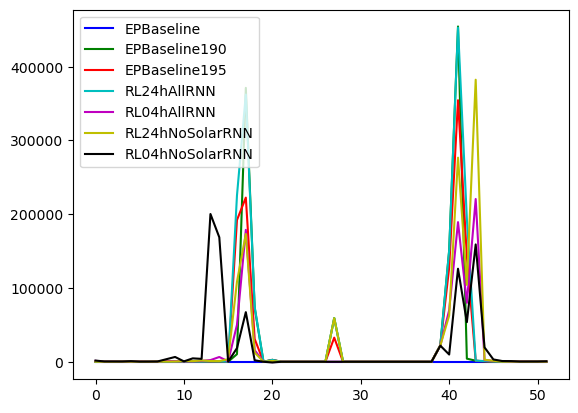

,0,1,2,colour
0,EPBaseline,0.0,0.0,b
1,EPBaseline190,1151638.542639,1151638.542639,g
2,EPBaseline195,1131868.835487,1131868.835487,r
3,RL24hAllRNN,1550631.031986,1550631.031986,c
4,RL04hAllRNN,848352.214758,848352.214758,m
5,RL24hNoSolarRNN,1218617.73345,1218617.73345,y
6,RL04hNoSolarRNN,875646.476899,875646.476899,k


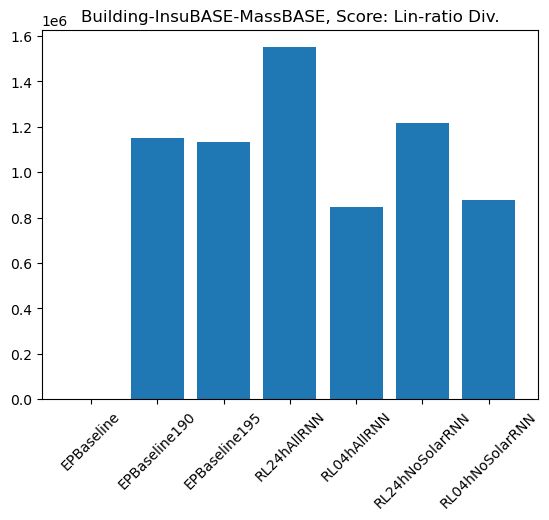

In [576]:
result_list = []

div_factor = 0.001
r = ( 0 , 52 )
df_used = df_weekly   # df_daily df_weekly df_monthly df_year


x = [i for i in range(df_used['open'][r[0]:r[1]].count())]
for i, control in enumerate(control_types_list):
    y = []
    for i2 in range(len(x)):
        if df_used[f'{control} deg-h cold'][r[0]+i2] != 0:
            y.append((df_used['EPBaseline MJ'][r[0]+i2] - df_used[f'{control} MJ'][r[0]+i2]) / (df_used[f'{control} deg-h cold'][r[0]+i2]  ))
        elif df_used[f'{control} deg-h cold'][r[0]+i2] == 0:
            y.append((df_used['EPBaseline MJ'][r[0]+i2] - df_used[f'{control} MJ'][r[0]+i2]) / div_factor)
    # y = ( (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) / (df_used[f'{control} deg-h cold'][r[0]:r[1]]  ))# if (df_used[f'{control} deg-h cold'][r[0]:r[1]]  ) != 0 else  (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) / div_factor)
    #  y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]]  ))
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]])) / ( p_base ** (df_used['EPBaseline deg-h cold'][r[0]:r[1]] )) - ((p_base ** df_used[f'{control} MJ'][r[0]:r[1]]) /( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] )))
    # y = y.clip(upper=70)

    y = pd.Series(y, index=df_used.index[r[0]:r[1]])
    # y = pd.DataFrame(y, index=df_used.index[r[0]:r[1]])

    df_used[f'{control} Lin_score'] = y 
    result = scipy.integrate.trapz(y, x)
    result_list.append(result)
    plt.plot(x, y, c[i])

plt.legend([i for i in control_types_list])
plt.show()


dict_df = pd.DataFrame([control_types_list, result_list])

# result_list
dict_df = dict_df.T
dict_df[2] = dict_df[1] - dict_df.iloc[0,1]
# dict_df[2].plot()
dict_df['colour'] = c[:len(result_list)]


plt.bar(dict_df[0], dict_df[2])
# plt.xlabel([dict_df[0]])#, rotated=45)
plt.xticks(rotation=45)
plt.title(f'{building}, Score: Lin-ratio Div.')
dict_df

# Linear Ratio Multiply

In [577]:
open_max = df_used['open'].max()
open_max

40

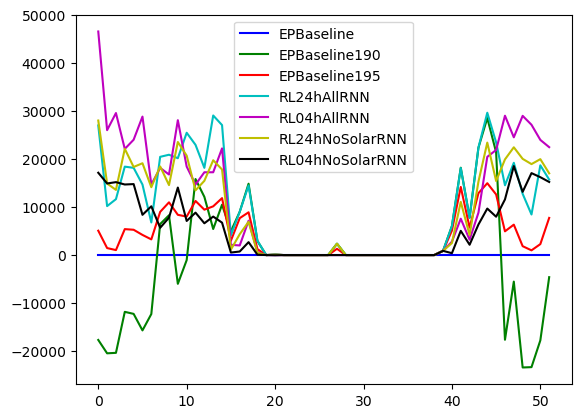

,0,1,2,colour
0,EPBaseline,0.0,0.0,b
1,EPBaseline190,-587.491528,-587.491528,g
2,EPBaseline195,211084.502046,211084.502046,r
3,RL24hAllRNN,500318.365081,500318.365081,c
4,RL04hAllRNN,543513.758666,543513.758666,m
5,RL24hNoSolarRNN,457733.01179,457733.01179,y
6,RL04hNoSolarRNN,272122.219566,272122.219566,k


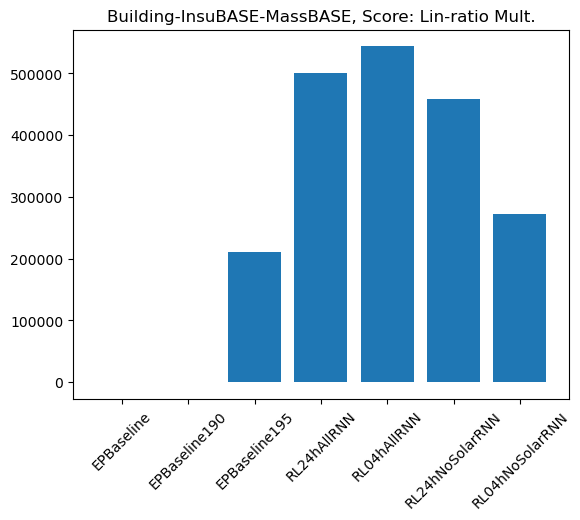

In [608]:
result_list = []


r = ( 0 , 52 )
df_used = df_weekly   # df_daily df_weekly df_monthly df_year
open_max = df_used['open'].max()
mul_factor = 0.4

x = [i for i in range(df_used['open'][r[0]:r[1]].count())]
for i, control in enumerate(control_types_list):
    
    y = ((df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) *  (df_used['open'][r[0]:r[1]] *mul_factor - df_used[f'{control} deg-h cold'][r[0]:r[1]]  ) ) / mul_factor
    # (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]]  ))
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]])) / ( p_base ** (df_used['EPBaseline deg-h cold'][r[0]:r[1]] )) - ((p_base ** df_used[f'{control} MJ'][r[0]:r[1]]) /( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] )))
    # y = y.clip(upper=70)

    # df_used[f'{control} Pow_score'] = y # (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] ))
    result = scipy.integrate.trapz(y, x)
    result_list.append(result)
    plt.plot(x, y, c[i])

plt.legend([i for i in control_types_list])
plt.show()


dict_df = pd.DataFrame([control_types_list, result_list])

# result_list
dict_df = dict_df.T
dict_df[2] = dict_df[1] - dict_df.iloc[0,1]
# dict_df[2].plot()
dict_df['colour'] = c[:len(result_list)]

plt.bar(dict_df[0], dict_df[2])
# plt.xlabel([dict_df[0]])#, rotated=45)
plt.xticks(rotation=45)
plt.title(f'{building}, Score: Lin-ratio Mult.')
dict_df

# Power ratio

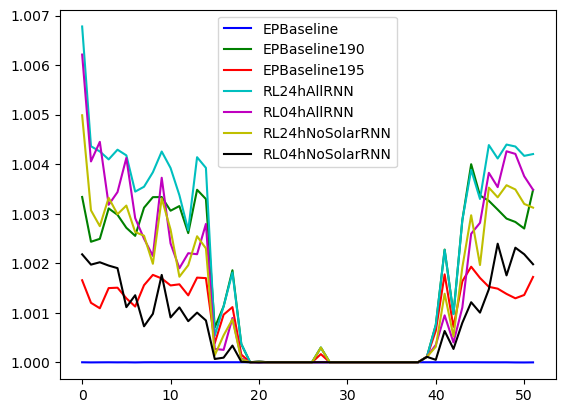

,0,1,2,colour
0,EPBaseline,50.999971,0.0,b
1,EPBaseline190,51.078573,0.078602,g
2,EPBaseline195,51.040633,0.040662,r
3,RL24hAllRNN,51.099529,0.099558,c
4,RL04hAllRNN,51.076246,0.076275,m
5,RL24hNoSolarRNN,51.069249,0.069278,y
6,RL04hNoSolarRNN,51.035229,0.035259,k


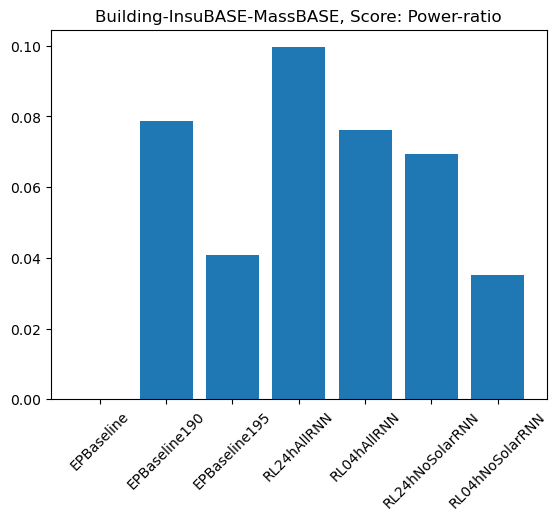

In [597]:
result_list = []

p_base = 1.000005
r = ( 0 , 52 )
df_used = df_weekly   # df_daily df_weekly df_monthly df_year


x = [i for i in range(df_used['open'][r[0]:r[1]].count())]
for i, control in enumerate(control_types_list):
    
    y = (p_base ** ( df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]] )  )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]]  ))
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]])) / ( p_base ** (df_used['EPBaseline deg-h cold'][r[0]:r[1]] )) - ((p_base ** df_used[f'{control} MJ'][r[0]:r[1]]) /( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] )))
    # y = y.clip(upper=70)

    df_used[f'{control} Pow_score'] = y # (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] ))
    result = scipy.integrate.trapz(y, x)
    result_list.append(result)
    plt.plot(x, y, c[i])

plt.legend([i for i in control_types_list])
plt.show()


dict_df = pd.DataFrame([control_types_list, result_list])

# result_list
dict_df = dict_df.T
dict_df[2] = dict_df[1] - dict_df.iloc[0,1]
# dict_df[2].plot()
dict_df['colour'] = c[:len(result_list)]
dict_df

plt.bar(dict_df[0], dict_df[2])
# plt.xlabel([dict_df[0]])#, rotated=45)
plt.xticks(rotation=45)
plt.title(f'{building}, Score: Power-ratio')
dict_df


In [580]:
# df_used

# Temperature graphs

Energy vs deg-hour

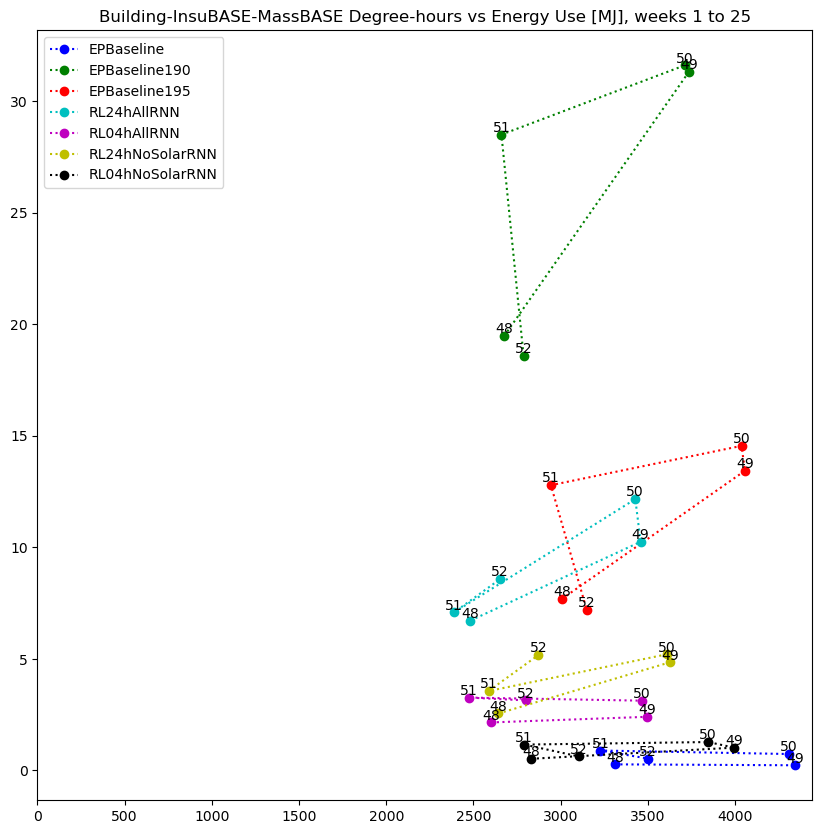

In [610]:
# result_list = []

p_base = 1.000005
# r = ( 0 , 12)
r = ( 47 , 52 )
df_used = df_weekly   # df_daily df_weekly df_year df_monthly

plt.figure(figsize=(10,10))

y_list = []
x_list = []

reduced_control_list = control_types_list[0:1]+control_types_list[2:4]
reduced_control_list = control_types_list

# x = [i for i in range(df_used['open'][r[0]:r[1]].count())]
for i, control in enumerate(reduced_control_list):

    x = df_used[f'{control} MJ'][r[0]:r[1]]
    y = df_used[f'{control} deg-h cold'][r[0]:r[1]]
    y_list.append(y)
    x_list.append(x)
    
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] ))
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]])) / ( p_base ** (df_used['EPBaseline deg-h cold'][r[0]:r[1]] )) - ((p_base ** df_used[f'{control} MJ'][r[0]:r[1]]) /( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] )))
    # y = y.clip(upper=70)

    # df_used[f'{control} score'] = y # (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] ))
    # result = scipy.integrate.trapz(y, x)
    # result_list.append(result)
    plt.plot(x, y, f'{c[i]}o:')

    for i, value in enumerate(x):
        plt.annotate([k for k in range(r[0],r[1])][i]+1, # this is the text
                 (x[i],y[i]),
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        

plt.legend([i for i in reduced_control_list])
plt.xlim(left=0)
plt.title(f'{building} Degree-hours vs Energy Use [MJ], weeks 1 to 25')
plt.show()


# dict_df = pd.DataFrame([control_types_list, result_list])

# # result_list
# dict_df = dict_df.T
# dict_df[2] = dict_df[1] - dict_df.iloc[0,1]
# dict_df[2].plot()
# dict_df['colour'] = c[:len(result_list)]
# dict_df


In [582]:
x_df.iloc[1]
# x_df

Date
2007-02-11    10088.489943
2007-02-18     8931.337944
2007-02-25     5605.824134
2007-03-04     7167.079370
2007-03-11     7889.584019
2007-03-18     5682.910928
2007-03-25     4526.018126
2007-04-01     3938.485556
2007-04-08     5113.348434
2007-04-15     5418.692801
Freq: W-SUN, Name: EPBaseline190 MJ, dtype: float64

In [583]:
list(x_df.iloc[:,0].values)

[10937.770926318928,
 10088.489942689035,
 10491.581307302558,
 10087.526535031502,
 10578.65572413163,
 10548.724012615205,
 10814.02564935253]

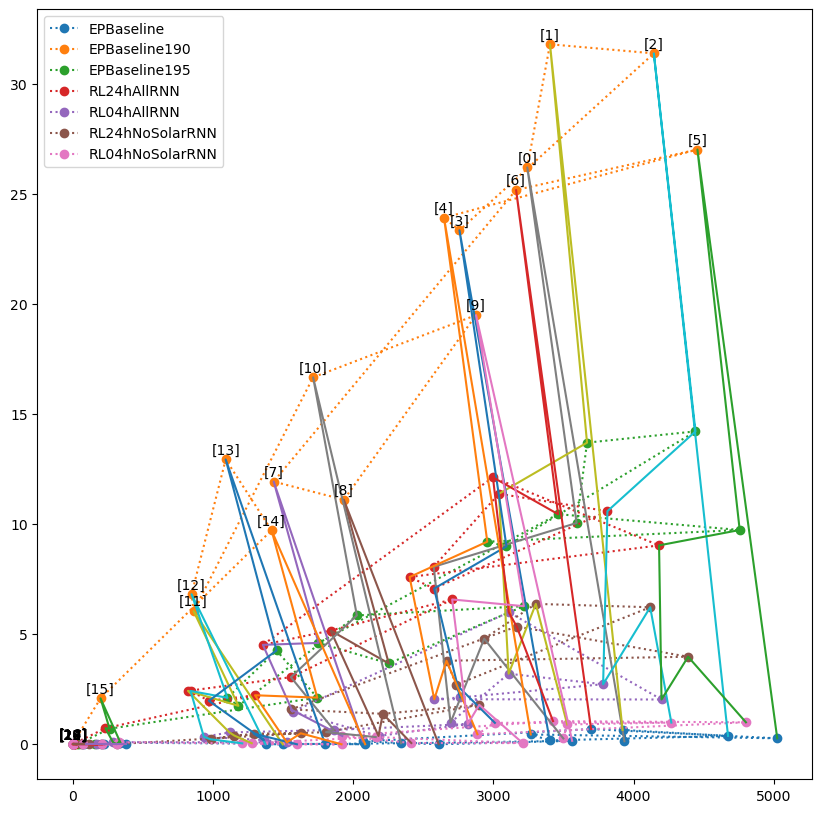

Date,2007-01-07,2007-01-14,2007-01-21,2007-01-28,2007-02-04,2007-02-11,2007-02-18,2007-02-25,2007-03-04,2007-03-11,...,2007-04-22,2007-04-29,2007-05-06,2007-05-13,2007-05-20,2007-05-27,2007-06-03,2007-06-10,2007-06-17,2007-06-24
EPBaseline deg-h cold,0.136413,0.651265,0.380412,0.173573,0.445002,0.270237,0.690996,0.128823,0.000000,0.156921,...,0.070061,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPBaseline190 deg-h cold,26.200836,31.792339,31.378937,23.342109,23.915089,27.013333,25.175548,11.930864,11.106323,19.490396,...,2.085090,0.021862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPBaseline195 deg-h cold,10.049684,13.699060,14.211783,8.988719,9.202419,9.732246,10.450763,4.603278,3.671815,6.272404,...,0.707442,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RL24hAllRNN deg-h cold,8.061496,11.377415,10.587419,7.072280,7.596195,9.033639,12.125024,4.516156,5.166480,6.577268,...,0.729149,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RL04hAllRNN deg-h cold,0.986218,3.203143,2.727130,2.126951,2.045704,2.033840,5.996564,1.479629,0.377143,0.918087,...,0.095210,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RL24hNoSolarRNN deg-h cold,4.795218,6.376347,6.223732,2.710952,3.793486,3.975040,5.348798,1.584364,1.383485,1.790598,...,0.008291,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RL04hNoSolarRNN deg-h cold,0.265706,0.899263,0.985221,0.973809,0.455796,0.997361,1.051256,0.376097,0.056445,0.053938,...,0.092282,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [592]:
y_df = pd.DataFrame(y_list)
# y_df.T.plot()

x_df = pd.DataFrame(x_list)
# x_df.T.plot()


#create scatterplot
# plt.scatter(x_df, y_df)


plt.figure(figsize=(10,10))

plt.plot(x_df.T, y_df.T, 'o:')
plt.legend([i for i in reduced_control_list])
plt.plot(x_df, y_df, '-')


df_range = [x for x in range(r[0],r[1])]
for i, value in enumerate(df_range):
    plt.annotate([value], # this is the text
                    (x_df.iloc[1,i],y_df.iloc[1,i]),
                    textcoords="offset points", # how to position the text
                    xytext=(0,4), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center
plt.show()
y_df


# x = [x for x in range(0,5000,500)]
#calculate equation for quadratic trendline
# z = np.polyfit(x_df.iloc[:,4], y_df.iloc[:,4], 2)
# p = np.poly1d(z)

# #add trendline to plot
# plt.plot(x, p(x))

'Adaptive comfort' chart

In [585]:
(control_types_list[0:1]+control_types_list[4:5])

['EPBaseline', 'RL04hAllRNN']

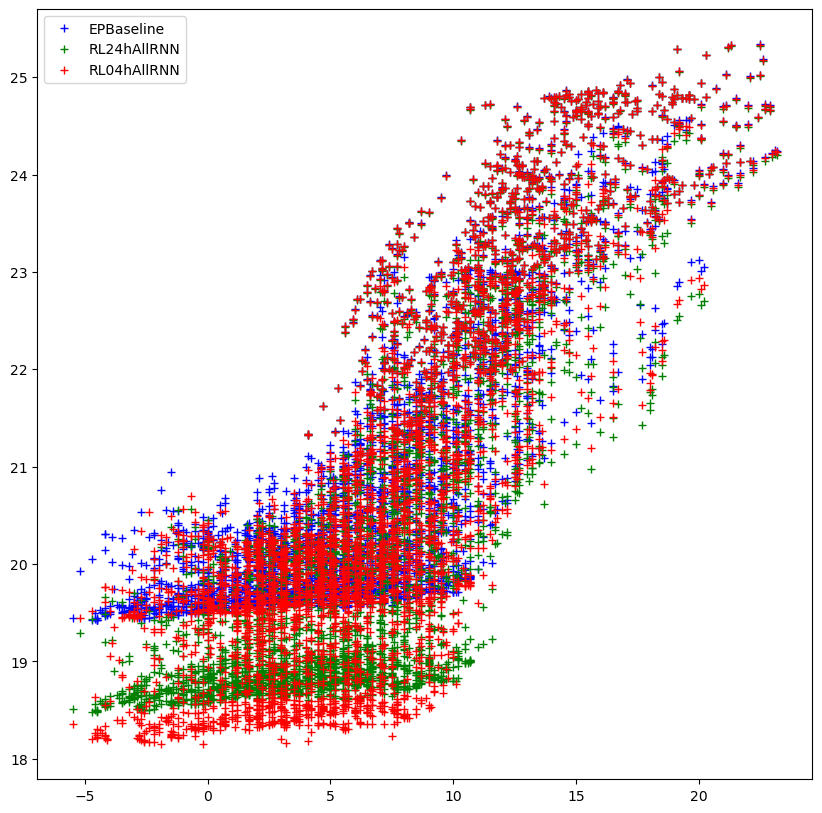

,0,1,2,colour
0,EPBaseline,50.999971,0.0,b
1,RL24hAllRNN,51.078573,0.078602,g
2,RL04hAllRNN,51.040633,0.040662,r
3,NaN,51.099529,0.099558,c
4,NaN,51.076246,0.076275,m
5,NaN,51.069249,0.069278,y
6,NaN,51.035229,0.035259,k


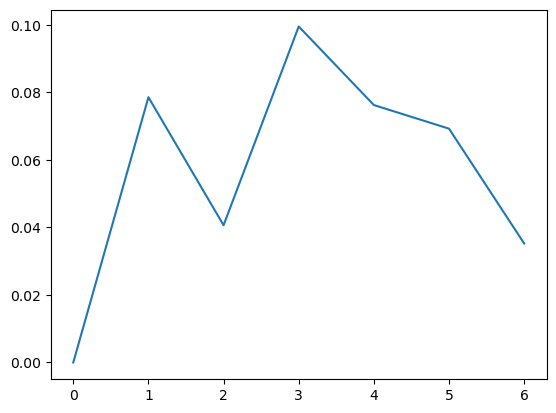

In [600]:
# result_list = []

r = ( 0 , 4300 )
df_used = df   # df_daily df_weekly df_monthly df_year

plt.figure(figsize=(10,10))
# x = [i for i in range(df_used['open'][r[0]:r[1]].count())]
reduced_control_list = control_types_list[0:1]+control_types_list[3:5]
for i, control in enumerate(reduced_control_list):

    # x = df_used[f'{control} MJ'][r[0]:r[1]]
    x = df_used[df_used['open'] >=0]['Ext Temperature'][r[0]:r[1]]
    y = df_used[df_used['open'] >=0][f'{control} Temp'][r[0]:r[1]]
    
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] ))
    # y = (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]])) / ( p_base ** (df_used['EPBaseline deg-h cold'][r[0]:r[1]] )) - ((p_base ** df_used[f'{control} MJ'][r[0]:r[1]]) /( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] )))
    # y = y.clip(upper=70)

    # df_used[f'{control} score'] = y # (p_base ** (df_used['EPBaseline MJ'][r[0]:r[1]] - df_used[f'{control} MJ'][r[0]:r[1]]) )/( p_base ** (df_used[f'{control} deg-h cold'][r[0]:r[1]] ))
    # result = scipy.integrate.trapz(y, x)
    # result_list.append(result)
    plt.plot(x, y, f'{c[i]}+')

plt.legend([i for i in reduced_control_list])

plt.show()


dict_df = pd.DataFrame([reduced_control_list, result_list])

# result_list
dict_df = dict_df.T
dict_df[2] = dict_df[1] - dict_df.iloc[0,1]
dict_df[2].plot()
dict_df['colour'] = c[:len(result_list)]
dict_df


In [587]:
for control in control_types_list:
    df[f'{control} score'][:500].rolling(50).mean().plot()
    # df[f'{control} score'].plot()
    print(control, ' ', df[f'{control} score'][:].clip(upper=1).sum())

KeyError: 'EPBaseline score'

In [ ]:
# Integral

# # saving_df_cold_capped = saving_df_cold.clip(upper=1)
# # saving_df_cold_capped

# result_list = []
# result_dict = {}
# for name in saving_df_cold.columns:
#     result = scipy.integrate.trapz(saving_df_cold[f'{name}'], [x for x in range(saving_df_cold[f'{name}'].count())])
#     result_dict[name] = result
#     result_list.append(result)

# dict_df = pd.DataFrame([saving_df_cold.columns, result_list])
# # result_list
# dict_df.T
# # print(result_dict)